In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import math
import warnings
from scipy.optimize import curve_fit
from scipy import integrate
import natural_cubic_spline_stack_overflow as ncs
import dynamic_stock_model as dsm 
warnings.simplefilter(action='ignore', category=FutureWarning)

## Total energy final consumption

In [20]:
TYP = ['TOT','AB','MFH','SFH','TH']
LT = [46,61,47,64]
DEV = [25,25,25,25]

DSM = pd.read_csv("Model/DSM_TOT.csv")
DSM = DSM.set_index('DSM')
DSM_AB = pd.read_csv("Model/DSM_AB.csv")
DSM_AB = DSM_AB.set_index('DSM AB')
DSM_MFH = pd.read_csv("Model/DSM_MFH.csv")
DSM_MFH = DSM_MFH.set_index('DSM MFH')
DSM_SFH = pd.read_csv("Model/DSM_SFH.csv")
DSM_SFH = DSM_SFH.set_index('DSM SFH')
DSM_TH = pd.read_csv("Model/DSM_TH.csv")
DSM_TH = DSM_TH.set_index('DSM TH')
display(DSM_TH)

DSM_all = [DSM,DSM_AB,DSM_MFH,DSM_SFH,DSM_TH]

,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM TH,,,,,,
1600,4.084715e+06,3.130503e+05,5.189356,NaN,NaN,NaN
1601,4.110000e+06,3.193367e+05,5.183755,NaN,NaN,NaN
1602,4.135285e+06,3.256198e+05,5.178230,NaN,NaN,NaN
1603,4.162227e+06,3.320701e+05,5.172784,NaN,NaN,NaN
1604,4.190827e+06,3.386923e+05,5.167413,NaN,NaN,NaN
...,...,...,...,...,...,...
2046,6.424131e+07,3.915770e+06,1.638996,NaN,NaN,NaN
2047,6.449291e+07,3.745831e+06,1.608827,NaN,NaN,NaN
2048,6.474451e+07,3.566700e+06,1.578470,NaN,NaN,NaN


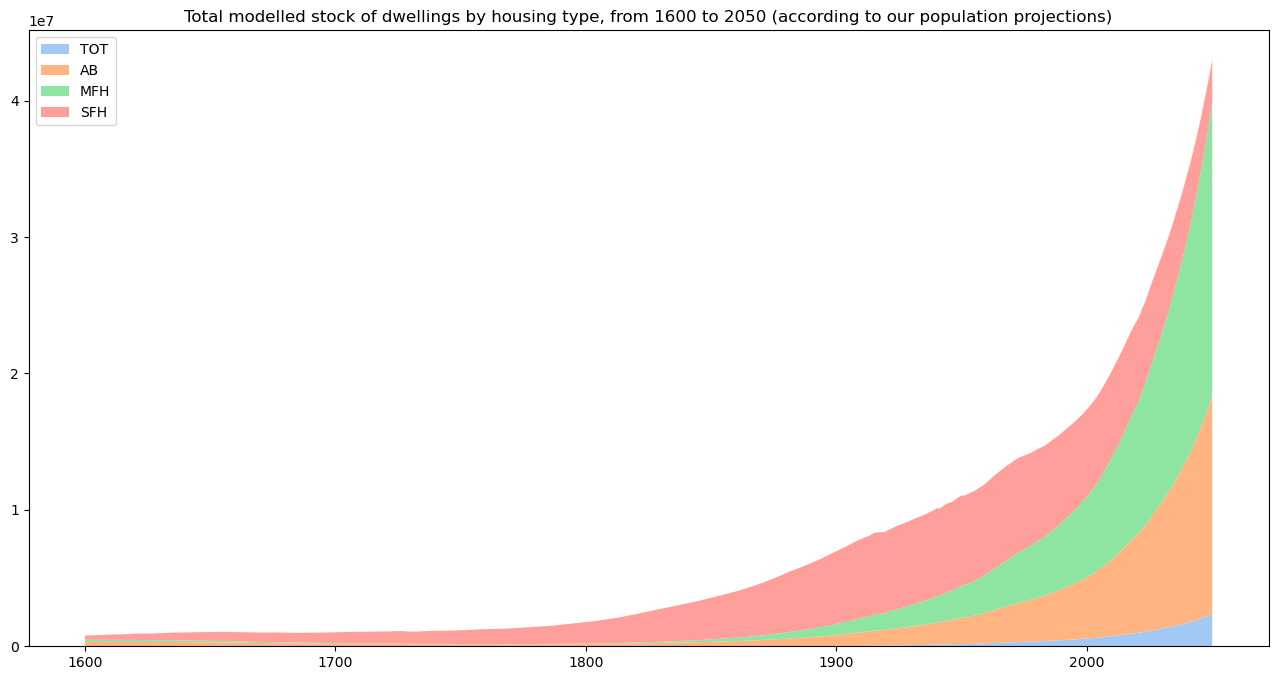

In [25]:
DSM_by_TYP = [dsm['Stock'].to_list() for dsm in DSM_all[1:]]
colors = sns.color_palette('pastel')[0:4]

plt.figure(figsize=(16,8))
plt.stackplot(DSM.index,DSM_by_TYP, labels=TYP, colors=colors)
plt.legend(loc='upper left')
plt.title('Total modelled stock of dwellings by housing type, from 1600 to 2050 (according to our population projections)')
plt.show()

# Raw energy final consumption for cohort-period corresponding to the years

Let's just apply the energy final consumption to the stock, abruptly, without considering the cohorts/inflow/outflow. 

We use the EPISCOPE data.

In [152]:
# Source : EPISCOPE 

file = "Data/EPISCOPE/Eng-energy-efficiency-score_updated.xlsx"
NRJ = pd.read_excel(file)
NRJ.columns = NRJ.loc[0,:]
NRJ = NRJ.drop(index=[0])

arrays = [
    NRJ['type'],
    NRJ['cohorts']
]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples)#, names=["type", "second"])

NRJ = NRJ.drop(columns=['type','cohorts'])
NRJ.index = index

display(NRJ)

# Missing values for AB => interpolation 

#print(NRJ.loc[('AB',['pre1919','1919_1944']),'AsBuilt'])

for reno in NRJ.columns:
    NRJ_AB = NRJ.loc['AB',reno]
    NRJ_AB = NRJ_AB.astype(float)
    NRJ_AB.index = [1919,1944,1964,1980,1999,2003,2009,2013]
    #display(NRJ_AB)
    NRJ_AB.interpolate(method='polynomial', order=2,axis=0,inplace=True)
    rate = (NRJ_AB.loc[1980]-NRJ_AB.loc[1964])/(1980-1964)
    NRJ_AB.loc[1944] = NRJ_AB.loc[1964]-rate*(1964-1944)
    NRJ_AB.loc[1919] = NRJ_AB.loc[1964]-rate*(1964-1919)
    rate = (NRJ_AB.loc[2009]-NRJ_AB.loc[2003])/(2009-2003)
    NRJ_AB.loc[2013] = NRJ_AB.loc[2009]+rate*(2013-2009)
    #display(NRJ_AB)
    NRJ.loc[('AB',['pre1919','1919_1944','1945_1964','1965_1980','1981_1990','1991_2003','2004_2009','post2010']),reno] = NRJ_AB.to_list()

display(NRJ)
display(NRJ.loc[('SFH','pre1919')]['AsBuilt'])

0             AsBuilt Standard_refurbishment Ambitious_refurbishment
SFH pre1919     247.3                   87.5                    77.6
    1919_1944   266.5                   94.7                    83.8
    1945_1964   259.8                    103                      92
    1965_1980     228                  138.5                    93.7
    1981_1990   166.3                  110.5                    90.2
    1991_2003   143.2                  103.6                    82.9
    2004_2009    69.6                   69.6                    66.3
    post2010     63.7                   47.1                    43.9
TH  pre1919     281.1                   89.9                    79.2
    1919_1944     310                   98.2                    85.8
    1945_1964   281.2                  107.9                    95.9
    1965_1980   221.4                  114.5                      94
    1981_1990     193                  114.2                    95.2
    1991_2003   176.4                  110.7                    92.2
    2004_2009    71.3                   71.3                    68.6
    post2010     64.9                   46.8                    43.6
MFH pre1919     205.5                   64.2                      58
    1919_1944   222.4                   69.5                    61.8
    1945_1964   219.1                   82.4                    72.9
    1965_1980   166.5                   85.2                    67.1
    1981_1990   128.4                   74.8                    61.5
    1991_2003   122.4                   81.2                      65
    2004_2009      55                     55                    52.8
    post2010     50.6                     35                    31.8
AB  pre1919       NaN                    NaN                     NaN
    1919_1944     NaN                    NaN                     NaN
    1945_1964   175.7                   56.5                    48.8
    1965_1980   121.9                   70.2                    51.8
    1981_1990     NaN                    NaN                     NaN
    1991_2003     NaN                    NaN                     NaN
    2004_2009    44.3                   44.3                    41.5
    post2010      NaN                    NaN                     NaN

0                AsBuilt Standard_refurbishment Ambitious_refurbishment
SFH pre1919        247.3                   87.5                    77.6
    1919_1944      266.5                   94.7                    83.8
    1945_1964      259.8                    103                      92
    1965_1980        228                  138.5                    93.7
    1981_1990      166.3                  110.5                    90.2
    1991_2003      143.2                  103.6                    82.9
    2004_2009       69.6                   69.6                    66.3
    post2010        63.7                   47.1                    43.9
TH  pre1919        281.1                   89.9                    79.2
    1919_1944        310                   98.2                    85.8
    1945_1964      281.2                  107.9                    95.9
    1965_1980      221.4                  114.5                      94
    1981_1990        193                  114.2                    95.2
    1991_2003      176.4                  110.7                    92.2
    2004_2009       71.3                   71.3                    68.6
    post2010        64.9                   46.8                    43.6
MFH pre1919        205.5                   64.2                      58
    1919_1944      222.4                   69.5                    61.8
    1945_1964      219.1                   82.4                    72.9
    1965_1980      166.5                   85.2                    67.1
    1981_1990      128.4                   74.8                    61.5
    1991_2003      122.4                   81.2                      65
    2004_2009         55                     55                    52.8
    post2010        50.6                     35                    31.8
AB  pre1919     327.0125               17.96875                 40.3625
    1919_1944     242.95                 39.375                   45.05
    1945_1964      175.7                   56.5                    48.8
    1965_1980      121.9                   70.2                    51.8
    1981_1990  68.159483              60.617193               47.343008
    1991_2003  58.249483              55.023305                45.29523
    2004_2009       44.3                   44.3                    41.5
    post2010   35.000345               37.15113               38.969847

247.3

In [166]:
# Hyp pour l'instant: 2050 a la même efficacité energétique que 

def Average(lst): 
    return sum(lst) / len(lst) 

def NRJ_fill(reno,NRJ_reno,Nergy):
    for t in NRJ_reno.columns.to_list()[1:]:
        for i in NRJ_reno.index:
            if i < 1919:
                #print('pre1919',i)
                value = Nergy.loc[(t,'pre1919')][reno]
                NRJ_reno.loc[i,t] = value
            elif 1919 <= i <= 1944:
                #print('pre44',i)
                NRJ_reno.loc[i,t] = Nergy.loc[(t,'1919_1944')][reno]
            elif 1945 <= i <= 1964:
                #print(i)
                NRJ_reno.loc[i,t] = Nergy.loc[(t,'1945_1964')][reno]
            elif 1965 <= i <= 1980:
                #print(i)
                NRJ_reno.loc[i,t] = Nergy.loc[(t,'1965_1980')][reno]
            elif 1981 <= i <= 1990:
                #print(i)
                NRJ_reno.loc[i,t] = Nergy.loc[(t,'1981_1990')][reno]
            elif 1991 <= i <= 2003:
                #print(i)
                NRJ_reno.loc[i,t] = Nergy.loc[(t,'1991_2003')][reno]
            elif 2004 <= i <= 2050:
                #print(i)
                NRJ_reno.loc[i,t] = Nergy.loc[(t,'2004_2009')][reno]
    for i in NRJ_reno.index:
        NRJ_reno.loc[i,'TOT'] = Average(NRJ_reno.loc[i,'AB':'TH'].to_list())
    return NRJ_reno

In [167]:
# MIGHT NOT BE TRUE IF KWH PER M2 !!!!!! 

NRJ_AsBuilt = pd.DataFrame(index=np.arange(1600,2051),columns=TYP)
NRJ_AsBuilt = NRJ_fill('AsBuilt',NRJ_AsBuilt,NRJ)
display(NRJ_AsBuilt)

,TOT,AB,MFH,SFH,TH
1600,265.228125,327.0125,205.5,247.3,281.1
1601,265.228125,327.0125,205.5,247.3,281.1
1602,265.228125,327.0125,205.5,247.3,281.1
1603,265.228125,327.0125,205.5,247.3,281.1
1604,265.228125,327.0125,205.5,247.3,281.1
...,...,...,...,...,...
2046,60.05,44.3,55,69.6,71.3
2047,60.05,44.3,55,69.6,71.3
2048,60.05,44.3,55,69.6,71.3
2049,60.05,44.3,55,69.6,71.3


In [183]:
# MIGHT NOT BE TRUE IF KWH PER M2 !!!!!! 

NRJ_stock_AsBuilt = NRJ_AsBuilt.copy(deep=True)
NRJ_stock_AsBuilt['TOT'] = [np.NaN for i in NRJ_stock_AsBuilt.index]

display(DSM_AB)
print(TYP)

for i in NRJ_stock_AsBuilt.index:
    ab = DSM_AB.loc[i,'Stock']
    NRJ_stock_AsBuilt.loc[i,'AB'] *= ab
    mfh = DSM_MFH.loc[i,'Stock']
    NRJ_stock_AsBuilt.loc[i,'MFH'] *= mfh 
    sfh = DSM_SFH.loc[i,'Stock']
    NRJ_stock_AsBuilt.loc[i,'SFH'] *= sfh
    th = DSM_TH.loc[i,'Stock']
    NRJ_stock_AsBuilt.loc[i,'TH'] *= th
    NRJ_stock_AsBuilt.loc[i,'TOT'] = NRJ_stock_AsBuilt.loc[i,'AB']+NRJ_stock_AsBuilt.loc[i,'MFH']+NRJ_stock_AsBuilt.loc[i,'SFH']+NRJ_stock_AsBuilt.loc[i,'TH']

display(NRJ_stock_AsBuilt)

,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM AB,,,,,,
1600,4.084715e+06,9.742592e+01,5.189356,NaN,NaN,NaN
1601,4.110000e+06,0.000000e+00,5.183755,NaN,NaN,NaN
1602,4.135285e+06,0.000000e+00,5.178230,NaN,NaN,NaN
1603,4.162227e+06,0.000000e+00,5.172784,NaN,NaN,NaN
1604,4.190827e+06,0.000000e+00,5.167413,NaN,NaN,NaN
...,...,...,...,...,...,...
2046,6.424131e+07,2.058621e+06,1.638996,NaN,NaN,NaN
2047,6.449291e+07,2.124264e+06,1.608827,NaN,NaN,NaN
2048,6.474451e+07,2.192892e+06,1.578470,NaN,NaN,NaN


['TOT', 'AB', 'MFH', 'SFH', 'TH']


,TOT,AB,MFH,SFH,TH
1600,1.919973e+08,31859.494922,65138539.127434,38828508.683842,87998426.295743
1601,1.936132e+08,0.0,65165179.815321,38682533.166029,89765533.414927
1602,1.952394e+08,0.0,65179449.579506,38528261.058197,91531719.249903
1603,1.969462e+08,0.0,65215413.66837,38385832.396715,93344909.533039
1604,1.987339e+08,0.0,65272639.227339,38254825.901061,95206410.428312
...,...,...,...,...,...
2046,2.475286e+09,91196922.819075,780914397.05033,1323980210.80541,279194428.677827
2047,2.529180e+09,94104908.287999,804257593.024646,1363739555.958814,267077757.120926
2048,2.585413e+09,97145134.543152,828662818.35764,1405299070.705731,254305722.531298
2049,2.644144e+09,100326565.525507,854202118.853833,1448780839.487437,240834291.8269


<AxesSubplot:ylabel='TOT'>

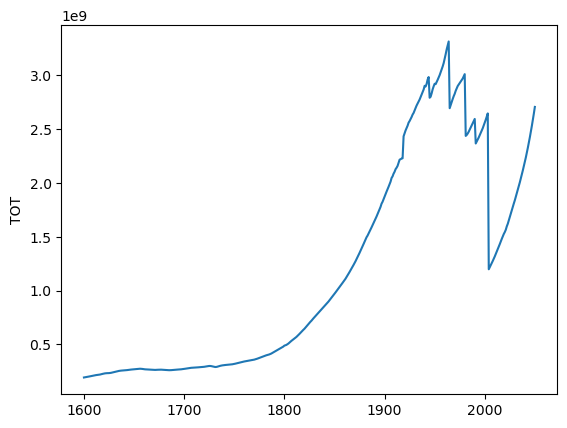

In [184]:
# MIGHT NOT BE TRUE IF KWH PER M2 !!!!!! 

sns.lineplot(NRJ_stock_AsBuilt,x=NRJ_stock_AsBuilt.index,y='TOT')

In [186]:
# Bennadji data 

cohorts = ['pre1919','1919_1944','1945_1964','1965_1980','1981_1990','1991_2003','2004_2009','post2010']
type_buildings = ['AB','MFH','SFH','TH']

Heated_floor = pd.DataFrame(index=type_buildings,columns=cohorts)

Heated_floor['pre1919'] = [68,70,198,104.62] # m2
Heated_floor['1919_1944'] = [59,60,153.41,93.01] # m2
Heated_floor['1945_1964'] = [56,63,134.4,87.72] # m2
Heated_floor['1965_1980'] = [63,62,123.08,85.32] # m2
Heated_floor['1981_1990'] = [68,62,149.35,98.4] # m2
Heated_floor['1991_2003'] = [68,62,149.35,98.4] # m2
Heated_floor['2004_2009'] = [68,62,149.35,98.4] # m2
Heated_floor['post2010'] = [68,62,149.35,98.4] # m2

display(Heated_floor)

# Could be precised with more accurate data ? 

Final_consumption = pd.DataFrame(index=type_buildings,columns=cohorts)

Final_consumption['pre1919'] = [156.86,196.48,284.99,349.53] # kWh/m2
Final_consumption['1919_1944'] = [140.06,156.23,323.11,359.39] # kWh/m2
Final_consumption['1945_1964'] = [188.52,210.46,340.63,365.01] # kWh/m2
Final_consumption['1965_1980'] = [177.11,174.34,273.15,278.03] # kWh/m2
Final_consumption['1981_1990'] = [90.96,81.16,105.41,114.88] # kWh/m2
Final_consumption['1991_2003'] = [90.96,81.16,105.41,114.88] # kWh/m2
Final_consumption['2004_2009'] = [90.96,81.16,105.41,114.88] # kWh/m2
Final_consumption['post2010'] = [90.96,81.16,105.41,114.88] # kWh/m2

display(Final_consumption)

Final_cons_dwe = Heated_floor*Final_consumption
display(Final_cons_dwe)

,pre1919,1919_1944,1945_1964,1965_1980,1981_1990,1991_2003,2004_2009,post2010
AB,68.00,59.00,56.00,63.00,68.00,68.00,68.00,68.00
MFH,70.00,60.00,63.00,62.00,62.00,62.00,62.00,62.00
SFH,198.00,153.41,134.40,123.08,149.35,149.35,149.35,149.35
TH,104.62,93.01,87.72,85.32,98.40,98.40,98.40,98.40


,pre1919,1919_1944,1945_1964,1965_1980,1981_1990,1991_2003,2004_2009,post2010
AB,156.86,140.06,188.52,177.11,90.96,90.96,90.96,90.96
MFH,196.48,156.23,210.46,174.34,81.16,81.16,81.16,81.16
SFH,284.99,323.11,340.63,273.15,105.41,105.41,105.41,105.41
TH,349.53,359.39,365.01,278.03,114.88,114.88,114.88,114.88


,pre1919,1919_1944,1945_1964,1965_1980,1981_1990,1991_2003,2004_2009,post2010
AB,10666.4800,8263.5400,10557.1200,11157.9300,6185.2800,6185.2800,6185.2800,6185.2800
MFH,13753.6000,9373.8000,13258.9800,10809.0800,5031.9200,5031.9200,5031.9200,5031.9200
SFH,56428.0200,49568.3051,45780.6720,33619.3020,15742.9835,15742.9835,15742.9835,15742.9835
TH,36567.8286,33426.8639,32018.6772,23721.5196,11304.1920,11304.1920,11304.1920,11304.1920


In [187]:
# Hyp pour l'instant: 2050 a la même efficacité energétique que 

def Average(lst): 
    return sum(lst) / len(lst) 

def NRJ_fill(NRJ_reno,Nergy):
    for t in Final_cons_dwe.index:
        for i in NRJ_reno.index:
            if i < 1919:
                #print('pre1919',i)
                NRJ_reno.loc[i,t] = Nergy.loc[t,'pre1919']
            elif 1919 <= i <= 1944:
                #print('pre44',i)
                NRJ_reno.loc[i,t] = Nergy.loc[t,'1919_1944']
            elif 1945 <= i <= 1964:
                #print(i)
                NRJ_reno.loc[i,t] = Nergy.loc[t,'1945_1964']
            elif 1965 <= i <= 1980:
                #print(i)
                NRJ_reno.loc[i,t] = Nergy.loc[t,'1965_1980']
            elif 1981 <= i <= 1990:
                #print(i)
                NRJ_reno.loc[i,t] = Nergy.loc[t,'1981_1990']
            elif 1991 <= i <= 2003:
                #print(i)
                NRJ_reno.loc[i,t] = Nergy.loc[t,'1991_2003']
            elif 2004 <= i <= 2050:
                #print(i)
                NRJ_reno.loc[i,t] = Nergy.loc[t,'2004_2009']
    for i in NRJ_reno.index:
        NRJ_reno.loc[i,'TOT'] = Average(NRJ_reno.loc[i,'AB':'TH'].to_list())
    return NRJ_reno

NRJ_AsBuilt = pd.DataFrame(index=np.arange(1600,2051),columns=TYP)
NRJ_AsBuilt = NRJ_fill(NRJ_AsBuilt,Final_cons_dwe)
display(NRJ_AsBuilt)

,TOT,AB,MFH,SFH,TH
1600,29353.98215,10666.48,13753.6,56428.02,36567.8286
1601,29353.98215,10666.48,13753.6,56428.02,36567.8286
1602,29353.98215,10666.48,13753.6,56428.02,36567.8286
1603,29353.98215,10666.48,13753.6,56428.02,36567.8286
1604,29353.98215,10666.48,13753.6,56428.02,36567.8286
...,...,...,...,...,...
2046,9566.093875,6185.28,5031.92,15742.9835,11304.192
2047,9566.093875,6185.28,5031.92,15742.9835,11304.192
2048,9566.093875,6185.28,5031.92,15742.9835,11304.192
2049,9566.093875,6185.28,5031.92,15742.9835,11304.192


In [198]:
NRJ_stock_AsBuilt = NRJ_AsBuilt.copy(deep=True)
NRJ_stock_AsBuilt['TOT'] = [np.NaN for i in NRJ_stock_AsBuilt.index]

display(DSM_AB)
print(TYP)

for i in NRJ_stock_AsBuilt.index:
    ab = DSM_AB.loc[i,'Stock']
    NRJ_stock_AsBuilt.loc[i,'AB'] *= ab
    mfh = DSM_MFH.loc[i,'Stock']
    NRJ_stock_AsBuilt.loc[i,'MFH'] *= mfh 
    sfh = DSM_SFH.loc[i,'Stock']
    NRJ_stock_AsBuilt.loc[i,'SFH'] *= sfh
    th = DSM_TH.loc[i,'Stock']
    NRJ_stock_AsBuilt.loc[i,'TH'] *= th
    NRJ_stock_AsBuilt.loc[i,'TOT'] = NRJ_stock_AsBuilt.loc[i,'AB']+NRJ_stock_AsBuilt.loc[i,'MFH']+NRJ_stock_AsBuilt.loc[i,'SFH']+NRJ_stock_AsBuilt.loc[i,'TH']

NRJ_stock_AsBuilt.index.name = 'NRJ [kWh]'
display(NRJ_stock_AsBuilt)

,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM AB,,,,,,
1600,4.084715e+06,9.742592e+01,5.189356,NaN,NaN,NaN
1601,4.110000e+06,0.000000e+00,5.183755,NaN,NaN,NaN
1602,4.135285e+06,0.000000e+00,5.178230,NaN,NaN,NaN
1603,4.162227e+06,0.000000e+00,5.172784,NaN,NaN,NaN
1604,4.190827e+06,0.000000e+00,5.167413,NaN,NaN,NaN
...,...,...,...,...,...,...
2046,6.424131e+07,2.058621e+06,1.638996,NaN,NaN,NaN
2047,6.449291e+07,2.124264e+06,1.608827,NaN,NaN,NaN
2048,6.474451e+07,2.192892e+06,1.578470,NaN,NaN,NaN


['TOT', 'AB', 'MFH', 'SFH', 'TH']


,TOT,AB,MFH,SFH,TH
NRJ [kWh],,,,,
1600,2.466792e+10,1039191.668196,4359559181.231534,8859748744.771498,11447568017.973925
1601,2.486523e+10,0.0,4361342175.708052,8826440578.82461,11677448025.985813
1602,2.506074e+10,0.0,4362297215.2637,8791239326.959814,11907208185.676891
1603,2.526653e+10,0.0,4364704201.602403,8758740469.86842,12143083075.37064
1604,2.548262e+10,0.0,4368534164.852232,8728847881.28433,12385242611.752951
...,...,...,...,...,...
2046,4.279173e+11,12733149046.825445,71445432232.827194,299474118003.39209,44264620295.995216
2047,4.375312e+11,13139169461.300169,73581088499.86499,308467375398.806641,42343593904.969284
2048,4.475640e+11,13563653674.651636,75813909253.639526,317867817279.966309,40318663593.162918


In [199]:
toe = 11.628 # kWh
ktoe = toe/10**3 # kWh 
print(ktoe)

NRJ_stock_AsBuilt_ktoe = NRJ_stock_AsBuilt*ktoe
NRJ_stock_AsBuilt_ktoe.index.name = 'NRJ [ktoe]'

display(NRJ_stock_AsBuilt_ktoe)

0.011628


,TOT,AB,MFH,SFH,TH
NRJ [ktoe],,,,,
1600,2.868385e+08,12083.720718,50692954.15936,103021158.404203,133112320.913001
1601,2.891329e+08,0.0,50713686.819133,102633851.050573,135785365.646163
1602,2.914063e+08,0.0,50724792.019086,102224530.893889,138457016.783051
1603,2.937992e+08,0.0,50752780.456233,101846634.18363,141199770.00041
1604,2.963120e+08,0.0,50797315.268902,101499043.163574,144015601.089463
...,...,...,...,...,...
2046,4.975823e+09,148061057.116486,830767486.003315,3482285044.143443,514709004.801832
2047,5.087613e+09,152782262.495998,855600897.07643,3586858641.137323,492371309.926983
2048,5.204275e+09,157718164.928849,881564136.80132,3696166979.331448,468825420.261298


TOT    3159074971.412107
AB       74248093.140309
MFH     441530513.691896
SFH     1839383064.02781
TH      803913300.552092
Name: 2022, dtype: object

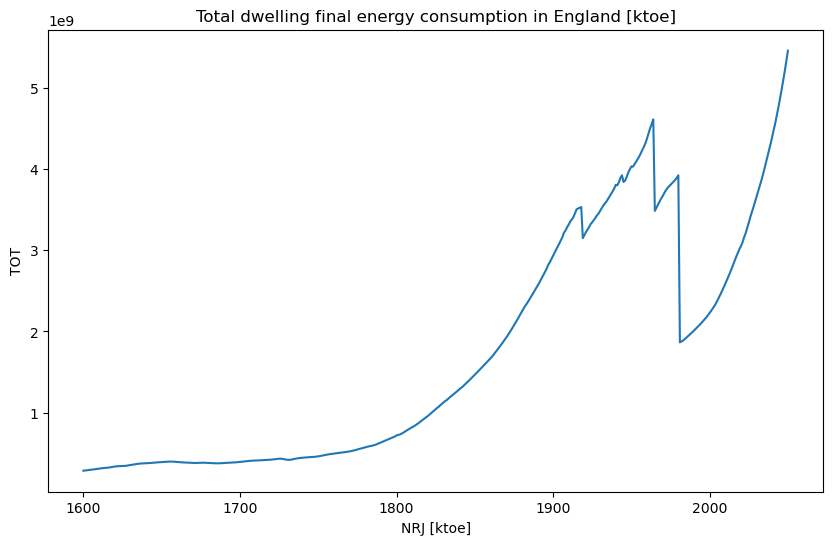

In [205]:
display(NRJ_stock_AsBuilt_ktoe.loc[2022,:])

plt.figure(figsize=(10,6))
ax = sns.lineplot(NRJ_stock_AsBuilt_ktoe,x=NRJ_stock_AsBuilt.index,y='TOT')
plt.title('Total dwelling final energy consumption in England [ktoe]')
fig = ax.get_figure()
fig.savefig("Output/dwe-tot-fin-cons.png",dpi=300,bbox_inches="tight")
plt.show()